# Outline

* cross sectional regression (problem of confoundedness)
* panel with unit fixed effects
    * unobserved time-varying confounders
    * short-run vs. long-run variation (adaptation)
    * average response vs. hetergeneity
    * "lack of variation"
* panel with unit fixed effects and trends
    * linear vs. quadratic trends
    * single vs. hetergeneous trends
* panel with time fixed effects
    * more flexible than trends
    * more likely to result in "lack of variation"
    * difficult to think about what the variation is (deviations from panel unit mean, again transformed to deviations from time period mean)

# Preliminaries

## Set up environment

* Install anaconda python from [here](https://www.continuum.io/downloads)
* Install julia from [here](http://julialang.org/downloads/)
* Add the following packages to julia using `Pkg.add()` from within julia:
    * IJulia (for interactive notebooks)
    * Gadfly (for plotting)
    * DataFrames (for working with tabular data)
    * FixedEffectModels (for high-dimensional panel regressions)
    * most of the rest of the packages listed [here](http://juliastats.github.io/) (Not used in this exercise, but will probably be useful in the future. In particular, it would be cool to figure out how to do cross validation of the regression methods in FixedEffectsModels.)
* Launch `jupyter-notebook`, either through the Anaconda Navigator or from the command line.
* From the jupyter homepage (which should open in your browser), navigate to the location where you have saved this file, and open it
    * Alternatively, in the upper-right corner select "New" -> "Julia [version]" to open a blank notebook where you can play around.

## Load Packages

In [2]:
using DataFrames
using FixedEffectModels
using Gadfly;

## Define functions

This function will be used to repeatedly create objects that can be used in regressions and plotting

In [3]:
function create_long_df(Y1, Y2, T1, T2, t)
    # start as wide
    dfWide = DataFrame(Y1 = Y1, Y2 = Y2, T1 = T1, T2 = T2, t = t)
    # add "month" column
    dfWide[:mo] = dfWide[:t] % 12
    dfWide[dfWide[:mo].==0,:mo] = 12
    # add "year" column
    dfWide[:yr] = round(Int64, ceil(dfWide[:t] / 12))
    
    # `stack` is used to reshape from wide to long, but it can only produce one "long" variable at a time,
    # so "T" and "Y" are reshaped separately
    dfT = rename(stack(dfWide, [:T1, :T2], [:t, :mo, :yr]), Dict{Any,Any}(:variable => :i, :value => :T))
    # `stack` takes the original column names and puts them in a column "variable", which I renames as "i" above
    # the map command converts the symbol to a string, and then to an integer containing only the last character of
    # the original variable name
    dfT[:i] = map(x->parse(Int64, string(x)[end]), dfT[:,:i])
    # reshape again for "Y"
    dfY = rename(stack(dfWide, [:Y1, :Y2], [:t, :mo, :yr]), Dict{Any,Any}(:variable => :i, :value => :Y))
    dfY[:i] = map(x->parse(Int64, string(x)[end]), dfY[:,:i])
    # merge the "T" and "Y" columns
    dfLong = join(dfY, dfT, on=[:i, :t, :mo, :yr])
    # convert panel unit, month, and year columns to "pooled" type so they can be used as fixed effects
    dfLong[:i] = pool(dfLong[:i])
    dfLong[:mo] = pool(dfLong[:mo])
    dfLong[:yr] = pool(dfLong[:yr])
    
    return dfLong
end

create_long_df (generic function with 1 method)

# Main exercise

## Cross-section

Below I set up a simple simulation of the temperature-outcome relationship in 2 distinct observational units

In [4]:
t = 1:360 # generic time period counter
# Panel unit 1
T1 = randn(360)*5+300 # temperatures normally distributed around 300
e1 = randn(360)*5 # white noise error
Y1 = 50*T1 + e1 + t - 14000 # coefficient of 50, secular trend, and a vertical shift for plotting

# Panel unit 1
T2 = randn(360)*5+320 # slightly higher average temperature
e2 = randn(360)*5 # white noise error
Y2 = 10*T2 + e2 + 2*t - 3000 # coefficient of 10, secular trend, and a vertical shift for plotting

# it will be helpful to refer to the data at different times using a long DataFrame and subsets corresponding to the panel units
dfLong = create_long_df(Y1, Y2, T1, T2, t)
df1, df2 = dfLong[dfLong[:i].==1, :], dfLong[dfLong[:i].==2,:];

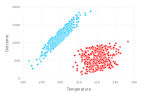

In [5]:
# add multiple "layers" to plot different data on the same axes
plot(
    layer(x=T1, y=Y1, Geom.point),
    layer(x=T2, y=Y2, Geom.point, Theme(default_color=colorant"red")),
    Guide.xlabel("Temperature"), Guide.ylabel("Outcome")
)

A very naive approach might compare the difference in average outcomes and divide by the difference in average temperatures

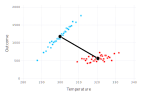

In [6]:
# calculate average outcome and average temperature for each panel unit
Ybar = [mean(df1[:Y]), mean(df2[:Y])]
Tbar = [mean(df1[:T]), mean(df2[:T])];

# this time show notation for plotting from a DataFrame
# also demonstrate use of `Stat.binmean` to reduce number of data points plotted
plot(
    layer(x=Tbar, y=Ybar, Geom.point, Geom.line, order=1, Theme(default_color=colorant"black", default_point_size=5pt, line_width=3pt)), 
    layer(df1, x=:T, y=:Y, Stat.binmean(n=36), Geom.point),
    layer(df2, x=:T, y=:Y, Stat.binmean(n=36), Geom.point, Theme(default_color=colorant"red")),
    Guide.xlabel("Temperature"), Guide.ylabel("Outcome")
)

A somewhat less naive comparison would be to "pool" observations and regress all of the outcomes on all of the temperatures

In [7]:
reg(Y ~ T, dfLong)

                            Linear Model                            
Number of obs:                720  Degree of freedom:              2
R2:                         0.289  R2 Adjusted:                0.288
F Statistic:               291.35  p-value:                    0.000
             Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
T            -18.4633   1.08169 -17.069    0.000  -20.5869  -16.3396
(Intercept)   6598.67   335.755 19.6532    0.000   5939.49   7257.85


--------------------------------------------------------------------


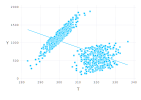

In [8]:
# very easily add linear fit line
plot(
    layer(dfLong, x=:T, y=:Y, Geom.point),
    layer(dfLong, x=:T, y=:Y, Geom.smooth(method=:lm)),
)

But, if we estimate the same model over a subset of the observations, we get very different coefficients.

In [9]:
mod1 = reg(Y ~ T, dfLong[dfLong[:i].==1,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              2
R2:                         0.855   R2 Adjusted:                0.855
F Statistic:              2116.77   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             50.5246   1.09816  46.0083    0.000    48.365   52.6843
(Intercept)  -13976.5   329.434 -42.4257    0.000  -14624.4  -13328.6


---------------------------------------------------------------------


In [10]:
mod2 = reg(Y ~ T, dfLong[dfLong[:i].==2,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              2
R2:                         0.039   R2 Adjusted:                0.036
F Statistic:               14.368   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             8.24617   2.17548  3.79051    0.000   3.96785   12.5245
(Intercept)  -2077.39   697.185 -2.97968    0.003  -3448.48  -706.295


---------------------------------------------------------------------


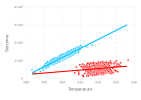

In [11]:
a1, b1 = coef(mod1)
a2, b2 = coef(mod2)
x = minimum(dfLong[:T]):maximum(dfLong[:T]);

# manually plotting the linear fit (could also use `Geom.smooth` here)
plot(
    layer(df1, x="T", y="Y", Geom.point), 
    layer(x=x, y=a1+b1*x, Geom.line, Theme(line_width=3pt), order=1), 
    layer(df2, x="T", y="Y", Geom.point, Theme(default_color=colorant"red")), 
    layer(x=x, y=a2+b2*x, Geom.line, Theme(line_width=3pt, default_color=colorant"red"), order=1), 
    Guide.xlabel("Temperature"), Guide.ylabel("Outcome")
)

Using the fact that we know these observation come from two distinct observational units, we can control for heterogeneity that is constant within a panel unit (and correlated with our regressors) using a panel unit fixed effect.

In [12]:
# this is the syntax for "Y regressed on T with panel unit (i) fixed effects"
mod_panelfe = reg(Y ~ T |> i, dfLong)

                     Fixed Effect Model                     
Number of obs:            720  Degree of freedom:          3
R2:                     0.751  R2 within:              0.359
F-Statistic:          401.838  p-value:                0.000
Iterations:                 1  Converged:               true
     Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
T     29.1553   1.45443 20.0459    0.000   26.2998   32.0107


------------------------------------------------------------


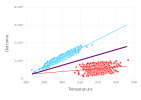

In [15]:
a = -8000
b_panelfe = coef(mod_panelfe)[1]

plot(
    layer(df1, x="T", y="Y", Geom.point), 
    layer(x=x, y=a1+b1*x, Geom.line, Theme(line_width=1pt), order=1), 
    layer(df2, x="T", y="Y", Geom.point, Theme(default_color=colorant"red")), 
    layer(x=x, y=a2+b2*x, Geom.line, Theme(line_width=1pt, default_color=colorant"red"), order=1), 
    layer(x=x, y=a+b_panelfe*x, Geom.line, Theme(line_width=3pt, default_color=colorant"purple"), order=1),
    Guide.xlabel("Temperature"), Guide.ylabel("Outcome")
)

The fixed effects model is mathematically equivalent to a model "in deviation form" where all variables (LHS and RHS) are transformed to differences from the average of that variable over all observations in the fixed effect category (i.e. the average of all observations for a particular panel unit).

Below is a demonstration that if we calculate these deviations ourselves and then estimate a model of "Y-tilde" on "T-tilde" *without fixed effects* we get the exact same coefficient as the original "Y" regressed on the original "T" *with* a panel unit fixed effect.

In [16]:
dfLong[:Ytilde] = dfLong[:Y] - mean(dfLong[dfLong[:i].==1, :Y])
dfLong[dfLong[:i].==2, :Ytilde] = dfLong[dfLong[:i].==2, :Y] - mean(dfLong[dfLong[:i].==2, :Y])

dfLong[:Ttilde] = dfLong[:T] - mean(dfLong[dfLong[:i].==1, :T])
dfLong[dfLong[:i].==2, :Ttilde] = dfLong[dfLong[:i].==2, :T] - mean(dfLong[dfLong[:i].==2, :T])

mod_deviation = reg(Ytilde ~ Ttilde, dfLong)

                               Linear Model                               
Number of obs:                   720   Degree of freedom:                 2
R2:                            0.359   R2 Adjusted:                   0.358
F Statistic:                 402.398   p-value:                       0.000
                Estimate Std.Error     t value Pr(>|t|) Lower 95% Upper 95%
Ttilde           29.1553   1.45341     20.0599    0.000   26.3018   32.0087
(Intercept)  1.62293e-12   7.30524 2.22159e-13    1.000  -14.3422   14.3422


---------------------------------------------------------------------------


Here, the key assumption required to interpret the temperature coefficient causally is that the deviation of temperature from the *within unit* average is exogenous. If so, then we have estimated the response to *short run* changes in temperature. There may be reason to believe that this response would change over time, either dampening as  units "gain experience" with similar exogenous temperature shocks, or possibly increasing as simple (cheap) adaptation measures are exhausted or become marginally more expensive.

## Trends and time fixed effects

### Trends

Single trend, heterogeneous trends

In [17]:
t = 1:360
T1 = randn(360)*5+300 + t/25
T2 = randn(360)*5+320 + t/5
e1 = randn(360)*5
e2 = randn(360)*5
Y1 = 50*T1 + e1 + 2*t - 14000
Y2 = 10*T2 + e2 + 4*t - 3000

# it will be helpful to refer to the data at different times using a long DataFrame and subsets corresponding to the panel units
dfLong = create_long_df(Y1, Y2, T1, T2, t)
df1, df2 = dfLong[dfLong[:i].==1, :], dfLong[dfLong[:i].==2,:];

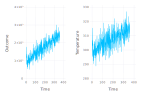

In [18]:
p1 = plot(x=t, y=Y1, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Outcome"))
p2 = plot(x=t, y=T1, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Temperature"))

hstack(p1, p2)

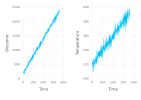

In [19]:
p1 = plot(x=t, y=Y2, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Outcome"))
p2 = plot(x=t, y=T2, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Temperature"))

hstack(p1, p2)

Because of the correlation between temperature and the exogenous trend, the temperature coefficient is biased.

In [20]:
reg(Y ~ T, dfLong[dfLong[:i].==1,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              2
R2:                         0.901   R2 Adjusted:                0.900
F Statistic:              3248.79   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             69.9113   1.22655  56.9982    0.000   67.4992   72.3235
(Intercept)  -19753.1   376.726 -52.4336    0.000  -20494.0  -19012.2


---------------------------------------------------------------------


In [21]:
reg(Y ~ T, dfLong[dfLong[:i].==2,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              2
R2:                         0.976   R2 Adjusted:                0.976
F Statistic:              14656.0   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             28.6438  0.236605  121.062    0.000   28.1785   29.1091
(Intercept)   -8913.0   84.3537 -105.662    0.000  -9078.89  -8747.11


---------------------------------------------------------------------


This bias also affects the ATE that we estimate.

In [22]:
reg(Y ~ T + t |> i, dfLong)

                     Fixed Effect Model                     
Number of obs:            720  Degree of freedom:          4
R2:                     0.954  R2 within:              0.947
F-Statistic:          3119.97  p-value:                0.000
Iterations:                 1  Converged:               true
     Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
T     16.9565  0.498848 33.9913    0.000   15.9771   17.9359
t     2.99845 0.0771894 38.8453    0.000    2.8469   3.14999


------------------------------------------------------------


But, controlling for a linear trend allows us to recover the true temperature coefficient for each unit, as well as the same ATE that we estimated before introducing the endogeneity problem.

In [23]:
mod1 = reg(Y ~ T + t, dfLong[dfLong[:i].==1,:])

                             Linear Model                             
Number of obs:                 360  Degree of freedom:               3
R2:                          1.000  R2 Adjusted:                 1.000
F Statistic:              1.9582e6  p-value:                     0.000
             Estimate  Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             50.0662  0.0470838  1063.34    0.000   49.9736   50.1588
t             1.99746 0.00308071  648.376    0.000    1.9914   2.00352
(Intercept)  -14019.9    14.1048 -993.978    0.000  -14047.6  -13992.1


----------------------------------------------------------------------


In [24]:
mod2 = reg(Y ~ T + t, dfLong[dfLong[:i].==2,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              3
R2:                         1.000   R2 Adjusted:                1.000
F Statistic:             786703.0   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             10.0367  0.048427  207.254    0.000   9.94147   10.1319
t             3.99612 0.0101124  395.169    0.000   3.97623   4.01601
(Intercept)  -3012.85   15.4661 -194.803    0.000  -3043.27  -2982.43


---------------------------------------------------------------------


In [25]:
reg(Y ~ T |> i + i&t, dfLong)

                     Fixed Effect Model                     
Number of obs:            720  Degree of freedom:          5
R2:                     0.972  R2 within:              0.698
F-Statistic:          1649.71  p-value:                0.000
Iterations:                 2  Converged:               true
     Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
T     30.4274  0.749138 40.6166    0.000   28.9567   31.8982


------------------------------------------------------------


Not allowing for heterogeneous trends results in a biased ATE

In [26]:
reg(Y ~ T + t|> i, dfLong)

                     Fixed Effect Model                     
Number of obs:            720  Degree of freedom:          4
R2:                     0.954  R2 within:              0.947
F-Statistic:          3119.97  p-value:                0.000
Iterations:                 1  Converged:               true
     Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
T     16.9565  0.498848 33.9913    0.000   15.9771   17.9359
t     2.99845 0.0771894 38.8453    0.000    2.8469   3.14999


------------------------------------------------------------


The plot below shows that the slope of the response line calculated from a linear model that *doesn't* control for the trend in each panel unit is biased.

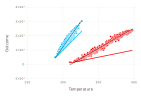

In [27]:
a1, b1 = coef(mod1)
a2, b2 = coef(mod2)
x1 = minimum(dfLong[dfLong[:i].==1, :T]):maximum(dfLong[dfLong[:i].==1, :T]);
x2 = minimum(dfLong[dfLong[:i].==2, :T]):maximum(dfLong[dfLong[:i].==2, :T]);

plot(
    layer(dfLong[dfLong[:i].==1,:], x=:T, y=:Y, Geom.point),
    layer(dfLong[dfLong[:i].==1,:], x=:T, y=:Y, Geom.smooth(method=:lm), Theme(default_color=colorant"black"), order=1),
    layer(x=x1, y=a1+b1*x1, Geom.line, Theme(line_width=2pt), order=1), 
    layer(dfLong[dfLong[:i].==2,:], x=:T, y=:Y, Geom.point, Theme(default_color=colorant"red")),
    layer(dfLong[dfLong[:i].==2,:], x=:T, y=:Y, Geom.smooth(method=:lm), Theme(default_color=colorant"black"), order=1),
    layer(x=x2, y=a2+b2*x2, Geom.line, Theme(line_width=2pt, default_color=colorant"red"), order=1), 
    Guide.xlabel("Temperature"), Guide.ylabel("Outcome")
)

### Time fixed effects

If the endogenous, time-varying component of temperature *is not* monotonic but *is* common to both panel units, then controlling for trends might not work.

In [28]:
t = 1:360
X = -30*cos(t/90);
T1 = randn(360)*5+300 + X
T2 = randn(360)*5+320 + X 
e1 = randn(360)*5
e2 = randn(360)*5
Y1 = 50*T1 + e1 + X - 14000 # opposite signs on X should produce negative correlation, downward bias on T1 coefficient
Y2 = 10*T2 + e2 + X - 3000 # opposite signs on X should produce negative correlation, downward bias on T2 coefficient

# it will be helpful to refer to the data at different times using a long DataFrame and subsets corresponding to the panel units
dfLong = create_long_df(Y1, Y2, T1, T2, t)
df1, df2 = dfLong[dfLong[:i].==1, :], dfLong[dfLong[:i].==2,:];

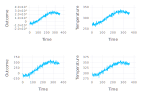

In [29]:
p1 = plot(x=t, y=Y1, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Outcome"))
p2 = plot(x=t, y=T1, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Temperature"))

pp1 = hstack(p1, p2)
p1 = plot(x=t, y=Y2, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Outcome"))
p2 = plot(x=t, y=T2, Geom.line, Guide.xlabel("Time"), Guide.ylabel("Temperature"))

pp2 = hstack(p1, p2)
vstack(pp1, pp2)

In [30]:
reg(Y ~ T, dfLong[dfLong[:i].==1,:])

                            Linear Model                            
Number of obs:                360  Degree of freedom:              2
R2:                         1.000  R2 Adjusted:                1.000
F Statistic:            1.00781e7  p-value:                    0.000
             Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
T             50.9557  0.016051 3174.61    0.000   50.9242   50.9873
(Intercept)  -14286.1   4.92048 -2903.4    0.000  -14295.8  -14276.4


In [31]:
reg(Y ~ T, dfLong[dfLong[:i].==2,:])

                            Linear Model                            
Number of obs:                360   Degree of freedom:              2
R2:                         0.999   R2 Adjusted:                0.999
F Statistic:            4.03292e5   p-value:                    0.000
             Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T             10.9671 0.0172697  635.053    0.000   10.9332   11.0011
(Intercept)  -3309.03   5.63654 -587.068    0.000  -3320.11  -3297.94


---------------------------------------------------------------------


In [32]:
reg(Y ~ T + t, dfLong[dfLong[:i].==2,:])

                             Linear Model                             
Number of obs:                 360  Degree of freedom:               3
R2:                          0.999  R2 Adjusted:                 0.999
F Statistic:              4.4811e5  p-value:                     0.000
              Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
T              10.6627 0.0413021  258.164    0.000   10.5815   10.7439
t            0.0691956 0.0086614  7.98896    0.000 0.0521618 0.0862294
(Intercept)   -3222.38   12.0279 -267.908    0.000  -3246.03  -3198.72


In [33]:
reg(Y ~ T |> yr, dfLong[dfLong[:i].==2,:])

                     Fixed Effect Model                     
Number of obs:            360  Degree of freedom:         31
R2:                     1.000  R2 within:              0.990
F-Statistic:          33895.2  p-value:                0.000
Iterations:                 1  Converged:               true
     Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
T     10.0275 0.0544657 184.107    0.000   9.92035   10.1346


------------------------------------------------------------
